In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import torch
import torch.optim as optim
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

# Homework 5 Question 2: Housing Training 

In [2]:
housing = pd.read_csv('Housing.csv')
vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']
data = housing[vars]
data.head()


,area,bedrooms,bathrooms,stories,parking,price
0,7420,4,2,3,2,13300000
1,8960,4,4,4,3,12250000
2,9960,3,2,2,2,12250000
3,7500,4,2,2,3,12215000
4,7420,4,1,2,2,11410000


In [3]:
data_scaled = StandardScaler()
data_scaled = data_scaled.fit_transform(data.values[:,:])
data_scaled = pd.DataFrame(data_scaled)
data_scaled.head()

,0,1,2,3,4,5
0,1.046726,1.403419,1.421812,1.378217,1.517692,4.566365
1,1.757010,1.403419,5.405809,2.532024,2.679409,4.004484
2,2.218232,0.047278,1.421812,0.224410,1.517692,4.004484
3,1.083624,1.403419,1.421812,0.224410,2.679409,3.985755
4,1.046726,1.403419,-0.570187,0.224410,1.517692,3.554979


In [4]:
y = data_scaled.values[:,5]

In [5]:
x = data_scaled.values[:,0:5]
x

array([[ 1.04672629,  1.40341936,  1.42181174,  1.37821692,  1.51769249],
       [ 1.75700953,  1.40341936,  5.40580863,  2.53202371,  2.67940935],
       [ 2.21823241,  0.04727831,  1.42181174,  0.22441013,  1.51769249],
       ...,
       [-0.70592066, -1.30886273, -0.57018671, -0.92939666, -0.80574124],
       [-1.03338891,  0.04727831, -0.57018671, -0.92939666, -0.80574124],
       [-0.5998394 ,  0.04727831, -0.57018671,  0.22441013, -0.80574124]])

In [6]:
# Converting data from array to tensors
x = torch.tensor(x)
y = torch.tensor(y)
x

tensor([[ 1.0467,  1.4034,  1.4218,  1.3782,  1.5177],
        [ 1.7570,  1.4034,  5.4058,  2.5320,  2.6794],
        [ 2.2182,  0.0473,  1.4218,  0.2244,  1.5177],
        ...,
        [-0.7059, -1.3089, -0.5702, -0.9294, -0.8057],
        [-1.0334,  0.0473, -0.5702, -0.9294, -0.8057],
        [-0.5998,  0.0473, -0.5702,  0.2244, -0.8057]], dtype=torch.float64)

In [7]:
# Splitting data into 20% testing and 80% training
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state = 0)
print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

torch.Size([436, 5]) torch.Size([109, 5]) torch.Size([436]) torch.Size([109])


In [8]:
# Setting Variables for testing data and validation data
# Training Data
areaTrain = xTrain[:,0]
bedTrain = xTrain[:,1]
bathTrain = xTrain[:,2]
storiesTrain = xTrain[:,3]
parkingTrain = xTrain[:,4]
priceTrain = yTrain

# Testing/ Validation Data
areaTest = xTest[:,0]
bedTest = xTest[:,1]
bathTest = xTest[:,2]
storiesTest = xTest[:,3]
parkingTest = xTest[:,4]
priceTest = yTest


In [9]:
def model(area, bed, bath, stories, parking, w1, w2, w3, w4, w5, b):
    return w5 * parking + w4 * stories + w3 * bath + w2 * bed + w1 * area + b

In [10]:
w1 = torch.ones(())
w2 = torch.ones(())
w3 = torch.ones(())
w4 = torch.ones(())
w5 = torch.ones(())
b = torch.zeros(())

t_p = model(areaTrain, bedTrain, bathTrain, storiesTrain, parkingTrain, w1, w2, w3, w4, w5, b)

In [11]:
# creating all functions

def dloss_fn(t_p, price):
    dsq_diffs = 2 * (t_p - price) / t_p.size(0)
    return dsq_diffs

def loss_fn(t_p, price):
    squared_diffs = (t_p - price)**2
    return squared_diffs.mean()

def dmodel_dw1(area, w1, b):
    return area
def dmodel_dw2(bed, w2, b):
    return bed
def dmodel_dw3(bath, w3, b):
    return bath
def dmodel_dw4(stories, w4, b):
    return stories
def dmodel_dw5(parking, w5, b):
    return parking

def dmodel_db(area, bed, bath, stories, parking, w1, w2, w3, w4, w5, b):
    return 1.0

def loss_fn(t_p, price):
    squared_diffs = (t_p - price)**2
    return squared_diffs.mean()

def grad_fn(area, bed, bath, stories, parking, price, t_p, w1, w2, w3, w4, w5, b):
    dloss_dtp = dloss_fn(t_p, price)
    dloss_dw1 = dloss_dtp * dmodel_dw1 (area, w1, b)
    dloss_dw2 = dloss_dtp * dmodel_dw2 (bed, w1, b)
    dloss_dw3 = dloss_dtp * dmodel_dw3 (bath, w1, b)
    dloss_dw4 = dloss_dtp * dmodel_dw4 (stories, w1, b)
    dloss_dw5 = dloss_dtp * dmodel_dw5 (parking, w1, b)
    dloss_db = dloss_dtp * dmodel_db(areaTrain, bedTrain, bathTrain, storiesTrain, parkingTrain, w1, w2, w3, w4, w5, b)
    return torch.stack([dloss_dw5.sum(),dloss_dw4.sum(),dloss_dw3.sum(),dloss_dw2.sum(), dloss_dw1.sum(), dloss_db.sum()])

def training_loop(n_epochs, learningRate, params, area, bed, bath, stories, parking, price):
    for epoch in range(1, n_epochs + 1):
        w1, w2, w3, w4, w5, b = params
        t_p = model(area, bed, bath, stories, parking, w1, w2, w3, w4, w5, b)
        loss = loss_fn(t_p, priceTrain)
        grad = grad_fn(area, bed, bath, stories, parking, price, t_p, w1, w2, w3, w4, w5, b)
        params = params - learningRate * grad
       
        if epoch == 1 or epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params
        

In [12]:
params = torch.tensor([1.0,1.0,1.0,1.0,1.0,0.0], requires_grad=True)
params

tensor([1., 1., 1., 1., 1., 0.], requires_grad=True)

In [13]:
rates = [0.1, 0.01, 0.001, 0.0001]
learningRate = rates[0]
learningRate

0.1

In [14]:
for learningRate in rates:
    print("When Learning Rate is", learningRate)
    params = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 0.0])
    learningRate = learningRate
    training_loop(
        n_epochs = 5000, 
        learningRate = learningRate, 
        params = params, 
        area = areaTrain, 
        bed = bedTrain, 
        bath = bathTrain, 
        stories = storiesTrain, 
        parking = parkingTrain, 
        price = priceTrain)
    print("")

When Learning Rate is 0.1
Epoch 1, Loss 5.965522
Epoch 500, Loss 45018092344817940879318730996028517228256162129903616.000000
Epoch 1000, Loss 100506248597411322874559684554890948085227543353514154639402746162994599280181761917246701884984454201475072.000000
Epoch 1500, Loss 224387777775704704433642966291207354387544653530626625711970612838055919885165562618156370489310693754693869495600859125299247076494447834776658877156299596890112.000000
Epoch 2000, Loss 500962631854039129048425619686171847039594498501716803237594430605126835149891846859706948481063764988533075858311843096524385046161485626157973580306683787931755602146721488002275093606125208851071944205902098202624.000000
Epoch 2500, Loss 1118436846257222122091440990813684457502925308988415462774665691340778013757082935766362296384292944136522775671877280299932716521200956254787175123544113098170245343304781177418133207049680672145550219656351447298229942048368548301267045099222909258930701889538074083328.000000
Epoch 3000, Loss 

The best rate for the training model is 0.0001

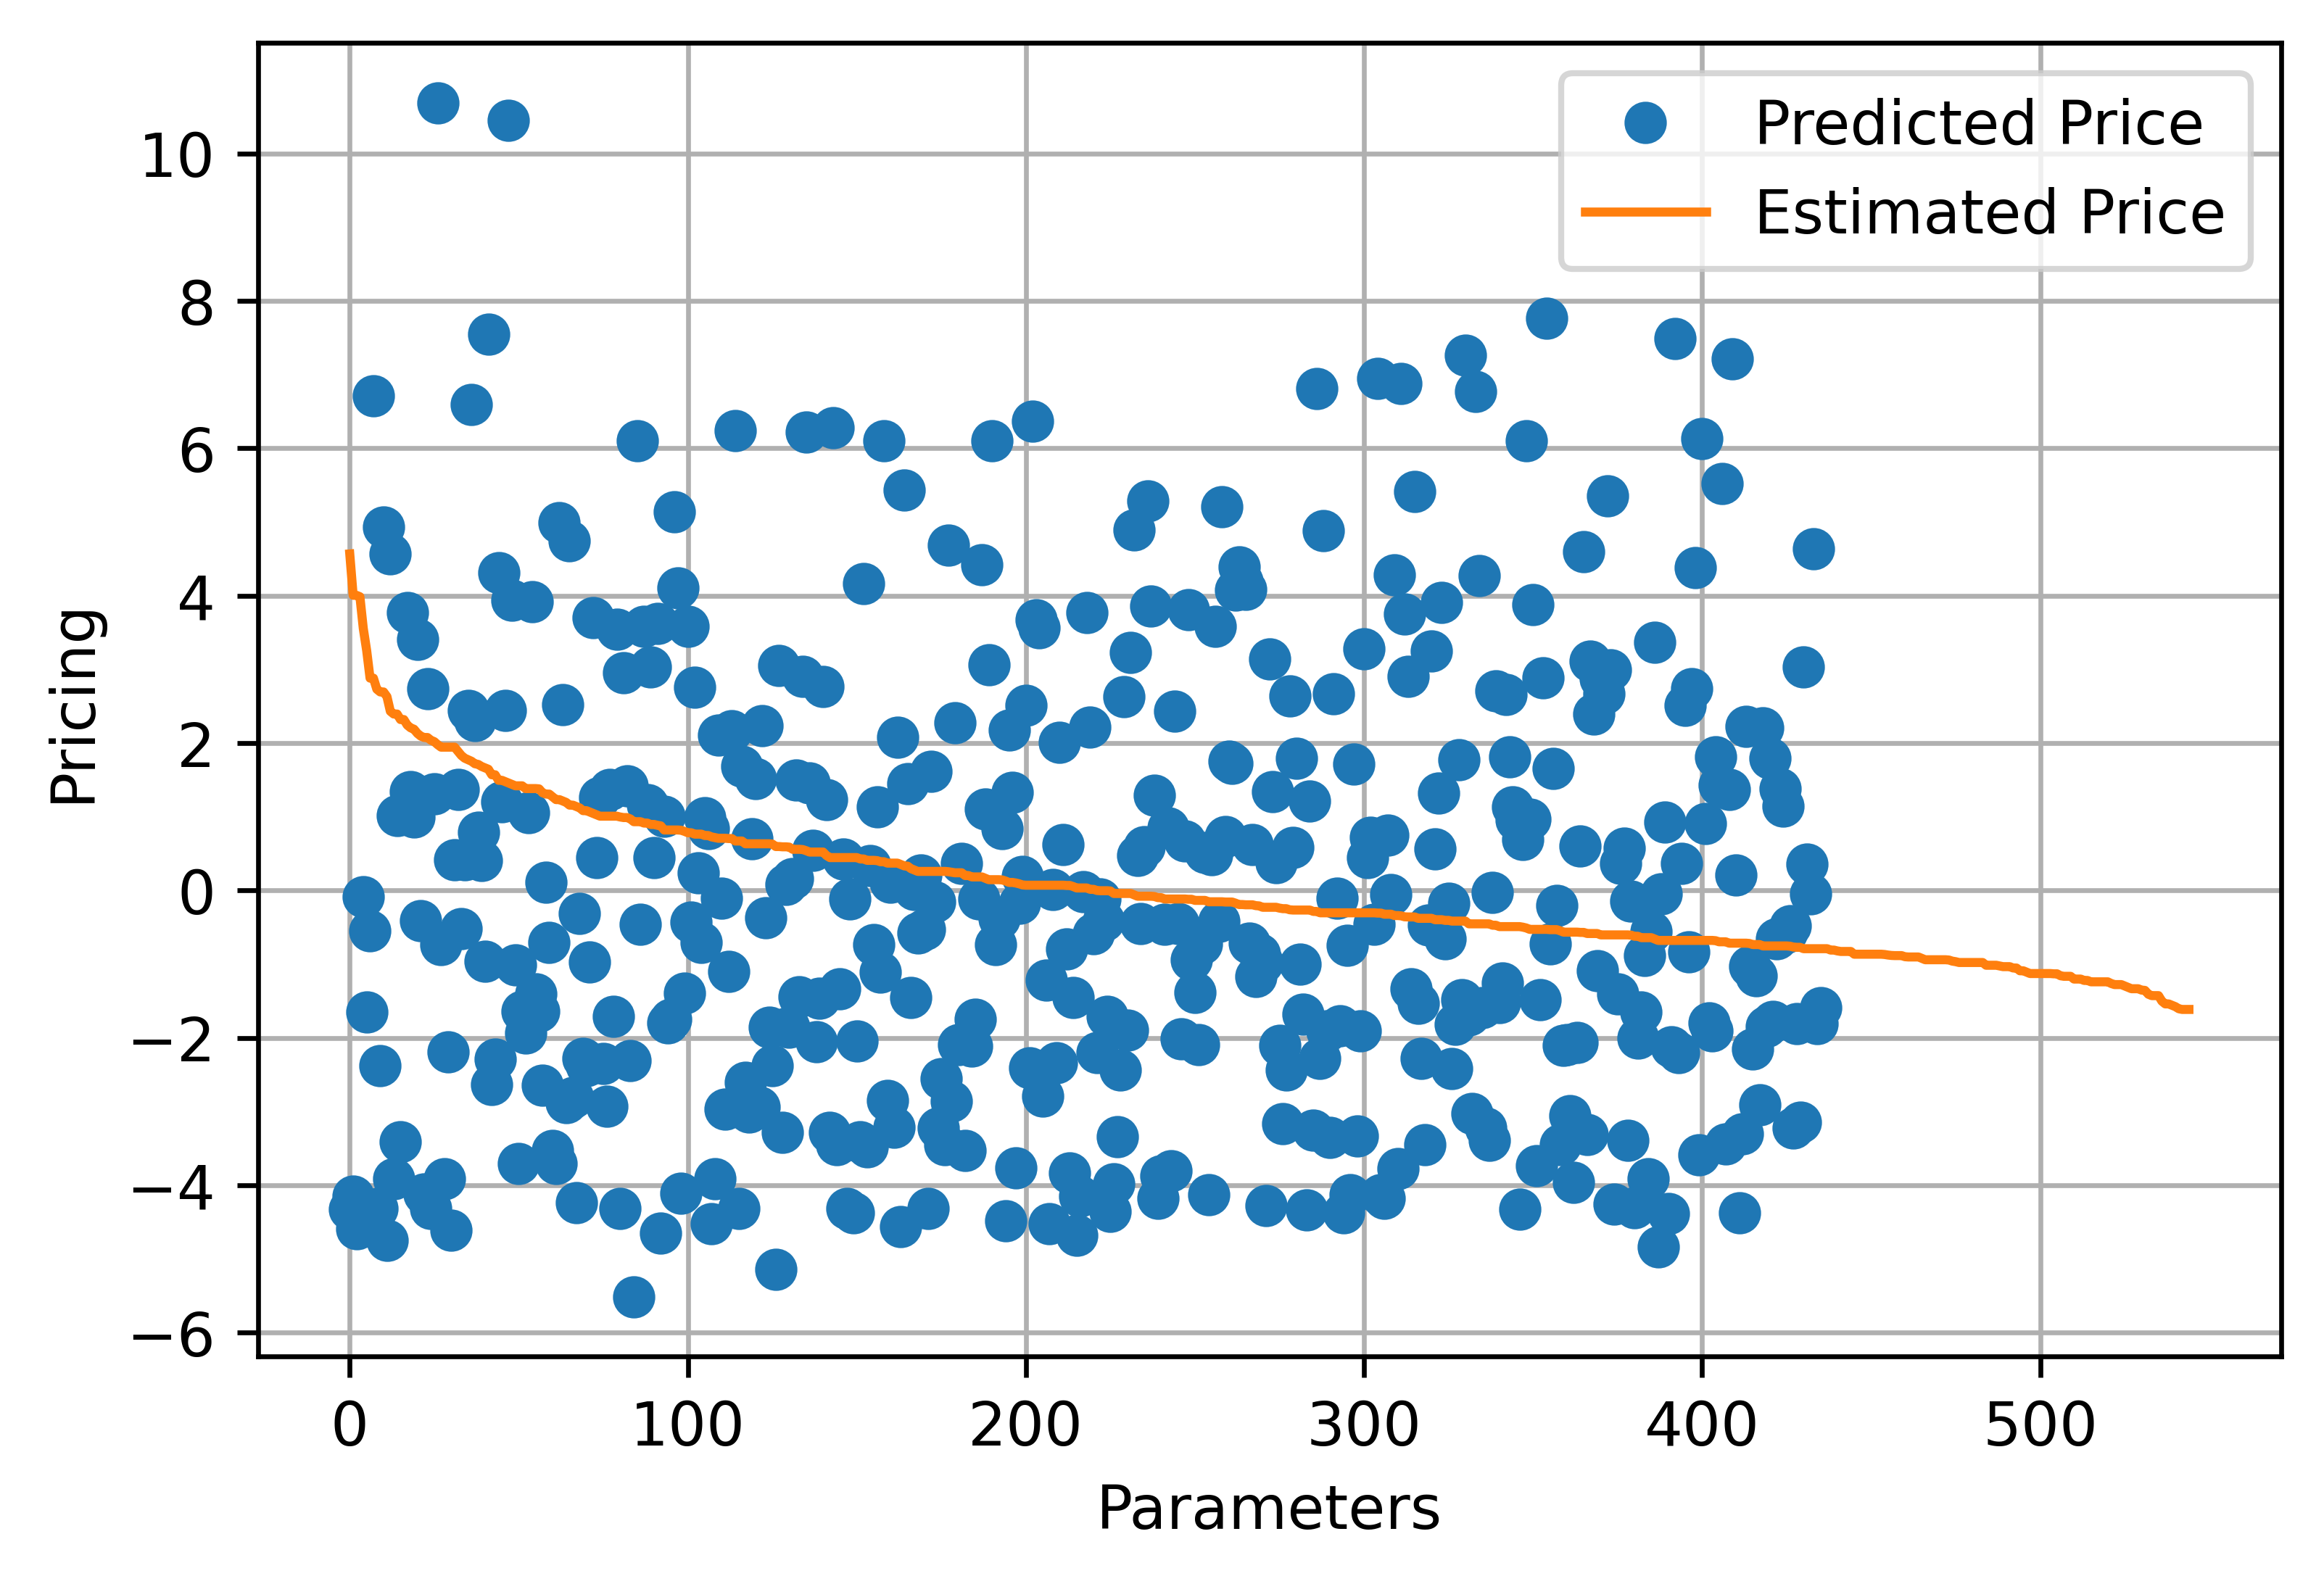

In [17]:
trainData = model(areaTrain, bedTrain, bathTrain, storiesTrain, parkingTrain,  w1, w2, w3, w4, w5, b)
testData = model(areaTest, bedTest, bathTest, storiesTest, parkingTest,  w1, w2, w3, w4, w5, b)
fig = plt.figure(dpi=600)

plt.xlabel("Parameters")
plt.ylabel("Pricing")
plt.plot(trainData.detach().numpy(), 'o', label = "Predicted Price")
plt.plot(y, label = "Estimated Price")
plt.legend()
plt.grid()
plt.show()